In [34]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotting_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reproducing the DRW Parameter Distributions for the SDSS S82 AGNs

__Author:__ Ji Won Park (@jiwoncpark) <br>
__Created:__ 08/08/2019 <br>
__Last run:__ 08/16/2019 <br>
__Goals:__
- Reproduce the plots in [MacLeod et al 2010](https://iopscience.iop.org/article/10.1088/0004-637X/721/2/1014) describing the dependence of the damped random walk (DRW) parameters on physical properties
- Confirm that my plotting code is consistent with that used by MacLeod et al 2010, so that it could be used to validate the DC2 AGNs (see separate notebook: `Validate_DC2_DRW.ipynb`)

### Downloading the data

MacLeod et al have published the data used in their 2010 modeling of AGN variability as a DRW [here](http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html). The page also has a detailed description of the schema. We'll first read in two of their data files summarizing the AGN light curves:
- `s82drw_<bandpass>.dat` contain the DRW parameters.
- `DB_QSO_S82.dat` contains the bolometric luminosities from the [Shen et al 2008](https://iopscience.iop.org/article/10.1086/587475) catalog for the same AGNs.

You can get them by running:
```bash
wget http://faculty.washington.edu/ivezic/macleod/qso_dr7/s82drw.tar.gz
tar -xvzf s8drw.tar.gz
wget http://faculty.washington.edu/ivezic/macleod/qso_dr7/DB_QSO_S82.dat.gz
gunzip DB_QSO_S82.dat.gz
```

If you are working locally, download the data and change the paths `drw_path` and `shen_path` accordingly. If you're on the NERSC Jupyter environment, you don't have to do anything.

In [4]:
# Define global quantities

# Normalizing wavelength
wavelength_norm = 4000.0 # in angstroms
# Central wavelength (value) for each SDSS bandpass (key) used to estimate the rest-frame wavelength
wavelength_center = {'u': 3520.0, 'g': 4800.0, 'r': 6250.0, 'i': 7690.0, 'z': 9110.0} # in angstroms
# Color (value) for each SDSS bandpass (key) used for plotting
color_dict = {'u': 'magenta', 'g': 'blue', 'r': 'green', 'i': 'orange', 'z': 'red'}

In [39]:
# Read DRW parameter data files, `s82drw_<bandpass>.dat`

drw_path = '/global/cscratch1/sd/jwp/agn_validation/sdss_s82_agn_data/s82drw_{:s}.dat'
drw_columns = ['SDR5ID', 'ra', 'dec', 'redshift', 'M_i_kcorr', 'log_mass_BH', 'chi2',
               'log_tau', 'log_sighat', 'log_tau_lowlim', 'log_tau_uplim', 'log_sfhat_lowlim', 'log_sfhat_uplim',
               'edge', 'll_model', 'll_noise', 'll_inf', 'mu', 'N_obs'] # taken from schema page

drw_dict = {} # dictionary of pandas dataframes, each dataframe representing the band
for bp in 'ugriz':
    drw_file = drw_path.format(bp)
    drw_bp = pd.read_csv(drw_file, index_col=False, sep='\s+', skiprows=3, names=drw_columns)
    z_corr = 1.0/(1.0 + drw_bp['redshift'].values) # z correction
    drw_bp['rf_wavelength'] = wavelength_center[bp]*z_corr/wavelength_norm # normalized rest-frame wavelength
    drw_bp['log_rf_tau'] = drw_bp['log_tau'].values - np.log10(1.0 + drw_bp['redshift'].values) # rest-frame tau
    drw_bp['log_sf_inf'] = drw_bp['log_sighat'].values - 0.5*drw_bp['log_tau'] # see Note (4) in schema
    drw_bp['bandpass'] = bp
    drw_bp['id'] = np.arange(len(drw_bp)) # can't use SDR5ID b/c collapses new QSOs as -1 (not unique)
    drw_dict[bp] = drw_bp

drw_all = pd.concat(drw_dict.values(), axis=0) # concat across bands

In [6]:
# Read Shen data file, `DB_QSO_S82.dat`

shen_path = '/global/cscratch1/sd/jwp/agn_validation/sdss_s82_agn_data/DB_QSO_S82.dat'
shen_columns = ['dbID', 'ra', 'dec', 'SDR51D', 'M_i', 'M_i_corr', 'redshift', 'mass_BH', 'Lbol', 
                'u', 'g', 'r', 'i', 'z', 'Au']

shen = pd.read_csv(shen_path, index_col=False, sep='\s+', skiprows=2, names=shen_columns)

### Note on the dataset size

The paper says there are 9275 AGNs, but the dataset only contains 9258. This is because 17 of the quasars had been demoted between the time of the publication and the time of the DR7 release. Details of this revision are [here](http://faculty.washington.edu/ivezic/macleod/qso_dr7/revisions.html).

In [17]:
for bp, bp_drw in drw_dict.items():
    print(bp, bp_drw.shape)

u (9258, 22)
g (9258, 22)
r (9258, 22)
i (9258, 22)
z (9258, 22)


### Selections

MacLeod et al applies three rounds of selection, which enforce the following criteria:
1. $N_{obs} >= 10$ (remove ones with too-few observations)
2. $ln \left( \frac{L_{model}}{L_{noise}} \right) > 2$ where $L_{model}$, $L_{noise}$ are model and noise likelihoods, respectively (remove ones better explained by uncorrelated noise than the model, i.e. too-noisy light curves)
3. $ln \left( \frac{L_{model}}{L_{\infty}} \right) > 0.05$ where $L_\infty$ is the likelihood that $\tau \rightarrow \infty$ (remove ones with light curves so short that the fitted $\tau$ is a lower limit)

In [40]:
# Apply selection

before_cut = len(drw_all)
print("Before selection: ", before_cut)
# 1.
drw_all = drw_all.query('N_obs >= 10')
after_1 = len(drw_all)
print("After Selection 1: ", after_1)
print("removed ", before_cut - after_1)
# 2.
drw_all['del_noise'] = drw_all['ll_model'] - drw_all['ll_noise']
drw_all = drw_all.query('del_noise > 2.0')
after_2 = len(drw_all)
print("After Selection 2: ", after_2)
print("removed ", after_1 - after_2)
# 3.
drw_all['del_inf'] = drw_all['ll_model'] - drw_all['ll_inf']
drw_all = drw_all.query('del_inf > 0.05')
after_3 = len(drw_all)
print("After Selection 3: ", after_3)
print("removed ", after_2 - after_3)

Before selection:  46290
After Selection 1:  45735
removed  555
After Selection 2:  42580
removed  3155
After Selection 3:  33238
removed  9342


As suggested in Note (5) in the [schema description](http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern_format_drw.html), we'll also remove AGNs on the edge of grid or too close to the edge for a proper centroid peak estimation.

In [41]:
drw_all = drw_all.query('edge == 0')
after_edgecut = len(drw_all)
print("After edge cut: ", after_edgecut)
print("removed ", after_3 - after_edgecut)

After edge cut:  33236
removed  2


### Distribution of rest-frame $\tau$

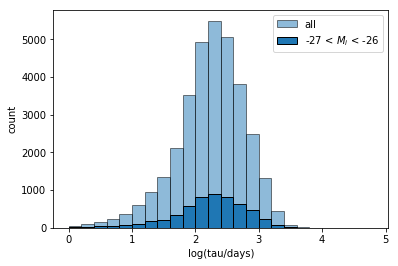

In [43]:
plot_log_rf_tau_hist(drw_all)

### Distribution of $SF_{\infty}$

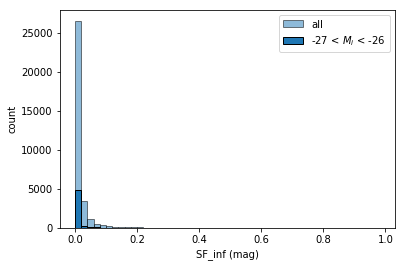

In [42]:
plot_sf_inf_hist(drw_all)

Text(0.5, 0, 'log(SF_inf/mag)')

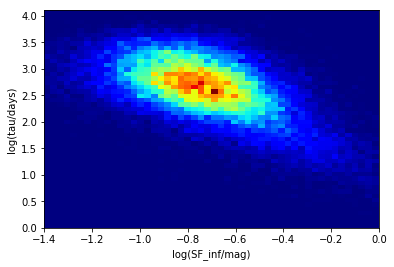

In [184]:
log_tau = all_bands['log_tau'].values
log_sf = all_bands['log_sf'].values
_ = plt.hist2d(log_sf, log_tau, bins=50, range=[[-1.4, 0], [0, 4.1]], cmap = plt.cm.jet)
plt.ylabel('log(tau/days)')
plt.xlabel('log(SF_inf/mag)')

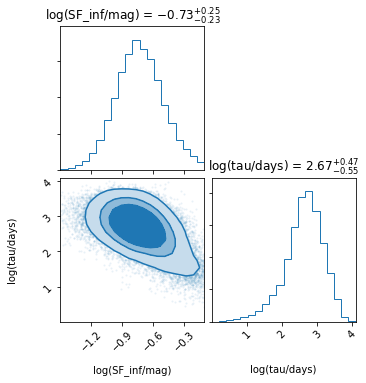

In [195]:
import corner

figure = corner.corner(all_bands[['log_sf', 'log_tau']].values,
                      color='tab:blue',
                      smooth=1.0,
                      labels=['log(SF_inf/mag)', 'log(tau/days)'],
                      fill_contours=True,
                      show_titles=True,
                      levels=[0.5, 0.7, 0.9],
                      range=[[-1.5, -0.1], [0, 4.1]],
                      hist_kwargs=dict(density=True))

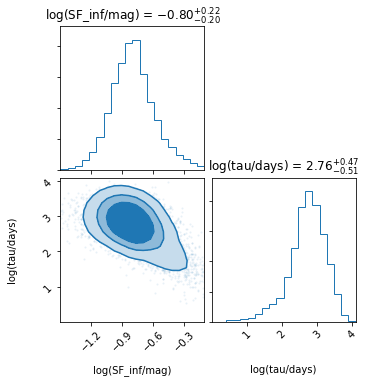

In [202]:
import corner

figure = corner.corner(all_bands[all_bands['bp']=='r'][['log_sf', 'log_tau']].values,
                      color='tab:blue',
                      smooth=1.0,
                      labels=['log(SF_inf/mag)', 'log(tau/days)'],
                      fill_contours=True,
                      show_titles=True,
                      levels=[0.5, 0.7, 0.9],
                      range=[[-1.5, -0.1], [0, 4.1]],
                      hist_kwargs=dict(density=True))

In [73]:
# Get QSOs observed in at least two filters
from collections import Counter

counts = Counter(all_bands.id)
fit_qso = all_bands[all_bands.id.isin([key for key in counts if counts[key] >= 2])]

In [76]:
fit_qso['id'].nunique()

7761

In [169]:
fit_qso.shape

(32537, 24)

In [158]:
# [np.arange(7.4, 10.9, 0.1), np.arange(-29, -23, 0.1), np.arange(0.5, 3.5, 0.1)]
H, edges = np.histogramdd(fit_qso[['mass_BH', 'M_i', 'redshift']].values,
                          bins=[np.arange(7.5, 11.0, 0.25), np.arange(-29, -23, 0.5), np.arange(0.5, 3.5, 0.01)])
H.shape, edges[0].size, edges[1].size, edges[2].size

#np.mean(H, axis=2).T

#plt.figure(figsize=(12, 6))
plt.imshow(np.mean(H, axis=2).T,
           interpolation=None, origin='low', extent=[edges[0][0], edges[0][-1]+0.25, edges[1][0], edges[1][-1] + 0.5],
           cmap='jet', vmin=0.5, vmax=3.5, aspect='auto')
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.ax.set_ylabel('redshift')
plt.ylabel('M_i')
plt.xlabel('log(M_BH/M_sun)')

Text(0, 0.5, 'log(N_bin)')

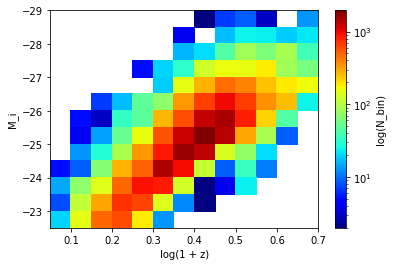

In [182]:
# [np.arange(7.4, 10.9, 0.1), np.arange(-29, -23, 0.1), np.arange(0.5, 3.5, 0.1)]
import matplotlib.colors as colors
x = np.log10(fit_qso['redshift'].values + 1.0)
y = fit_qso['M_i'].values
_ = plt.hist2d(x, y, bins=[np.arange(0.05, 0.75, 0.05), np.arange(-29, -22, 0.5)],
                cmap = plt.cm.jet, norm=colors.LogNorm())
plt.ylabel('M_i')#
plt.xlabel('log(1 + z)')
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(N_bin)')

Text(0, 0.5, 'log(N_bin)')

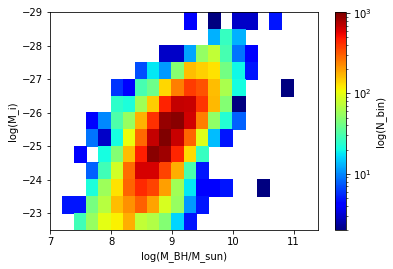

In [183]:
# [np.arange(7.4, 10.9, 0.1), np.arange(-29, -23, 0.1), np.arange(0.5, 3.5, 0.1)]
import matplotlib.colors as colors
x = fit_qso['mass_BH'].values
y = fit_qso['M_i'].values
_ = plt.hist2d(x, y, bins=[np.arange(7.0, 11.5, 0.2), np.arange(-29, -22, 0.5)],
               cmap = plt.cm.jet, norm=colors.LogNorm())
plt.ylabel('log(M_i)')#
plt.xlabel('log(M_BH/M_sun)')
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(N_bin)')

In [216]:
fit_qso['rf_lam'] = np.log10(fit_qso['rf_wavelength'])


/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


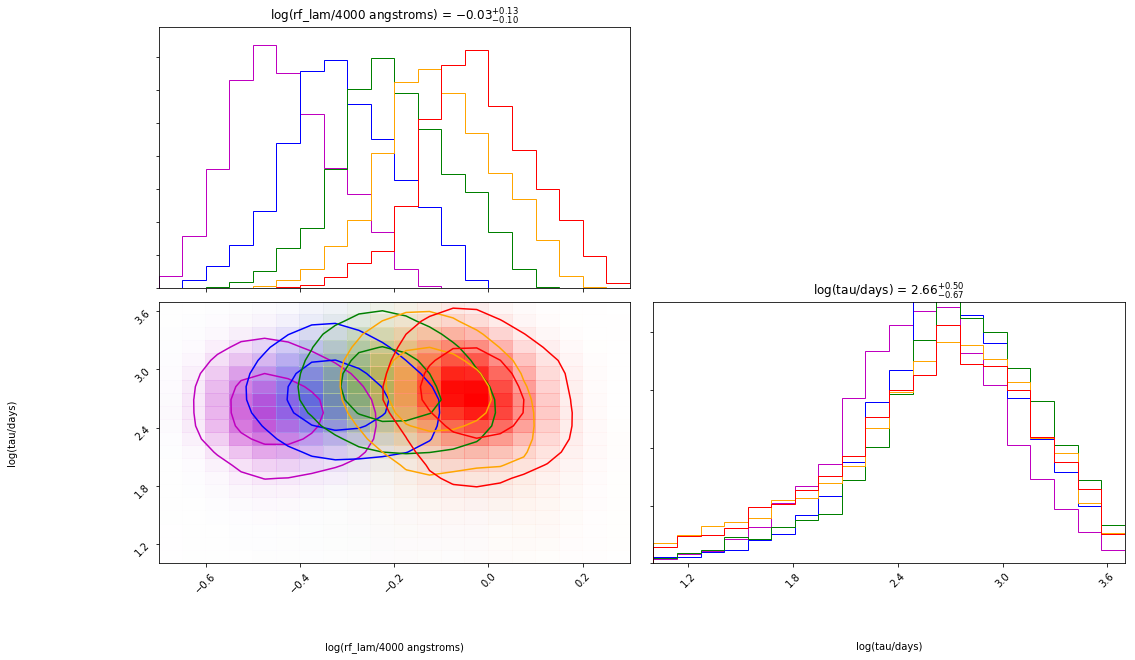

In [235]:
color_dict = dict(zip(list('ugriz'), ['m', 'b', 'green', 'orange', 'red']))
fig = corner.corner(fit_qso[fit_qso['bp']=='u'][['rf_lam', 'log_tau']].values,
                      color='m',
                      smooth=1.0,
                      labels=['log(rf_lam/4000 angstroms)', 'log(tau/days)'],
                      #fill_contours=False,
                    no_fill_contours=True,
                    plot_datapoints=False,
                    plot_contours=True,
                      show_titles=True,
                      levels=[0.3, 0.7],
                      range=[[-0.7, 0.3], [1, 3.7]],
                      hist_kwargs=dict(density=True),
                   contour_kwargs=dict(linestyles='solid'))
for bp in 'griz':
    fig = corner.corner(fit_qso[fit_qso['bp']==bp][['rf_lam', 'log_tau']].values,
                      color=color_dict[bp],
                      smooth=1.0,
                      labels=['log(rf_lam/4000 angstroms)', 'log(tau/days)'],
                      #fill_contours=False,
                    no_fill_contours=True,
                    plot_datapoints=False,
                    plot_contours=True,
                      show_titles=True,
                  fig=fig,
                      levels=[0.3, 0.7],
                      range=[[-0.7, 0.3], [1, 3.7]],
                      hist_kwargs=dict(density=True),
                   contour_kwargs=dict(linestyles='solid'))
fig.set_size_inches(18, 10, forward=True)

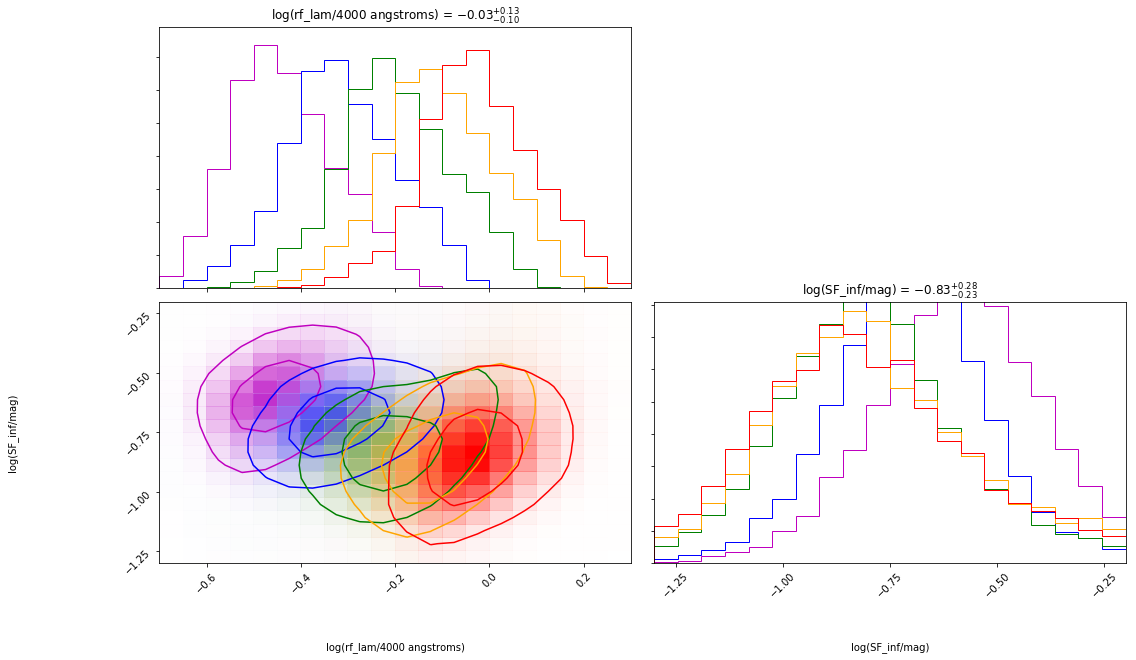

In [240]:
color_dict = dict(zip(list('ugriz'), ['m', 'b', 'green', 'orange', 'red']))
fig = corner.corner(fit_qso[fit_qso['bp']=='u'][['rf_lam', 'log_sf']].values,
                      color='m',
                      smooth=1.0,
                      labels=['log(rf_lam/4000 angstroms)', 'log(SF_inf/mag)'],
                      #fill_contours=False,
                    no_fill_contours=True,
                    plot_datapoints=False,
                    plot_contours=True,
                      show_titles=True,
                      levels=[0.3, 0.7],
                      range=[[-0.7, 0.3], [-1.3, -0.2]],
                      hist_kwargs=dict(density=True),
                   contour_kwargs=dict(linestyles='solid'))
for bp in 'griz':
    fig = corner.corner(fit_qso[fit_qso['bp']==bp][['rf_lam', 'log_sf']].values,
                      color=color_dict[bp],
                      smooth=1.0,
                      labels=['log(rf_lam/4000 angstroms)', 'log(SF_inf/mag)'],
                      #fill_contours=False,
                    no_fill_contours=True,
                    plot_datapoints=False,
                    plot_contours=True,
                      show_titles=True,
                  fig=fig,
                      levels=[0.3, 0.7],
                      range=[[-0.7, 0.3], [-1.3, -0.2]],
                      hist_kwargs=dict(density=True),
                   contour_kwargs=dict(linestyles='solid'))
fig.set_size_inches(18, 10, forward=True)

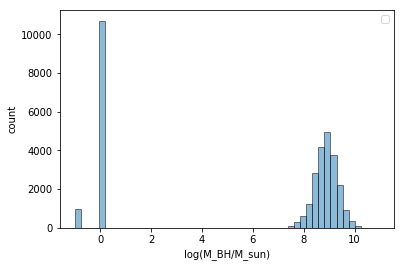

In [262]:
_, binning, _ = plt.hist(all_bands['mass_BH'].values,
                         bins=50, color='tab:blue', edgecolor='k', alpha=0.5)#, label='M_i=-28')
plt.ylabel('count')
plt.xlabel('log(M_BH/M_sun)')
plt.legend()

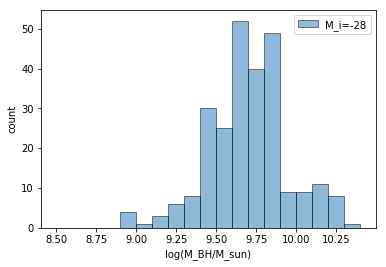

In [252]:
_, binning, _ = plt.hist(all_bands[(all_bands['M_i'] > -28.5) & (all_bands['M_i'] < -27.5)]['mass_BH'].values,
                         bins=np.arange(8.5, 10.5, 0.1), color='tab:blue', edgecolor='k', alpha=0.5, label='M_i=-28')
plt.ylabel('count')
plt.xlabel('log(M_BH/M_sun)')
plt.legend()

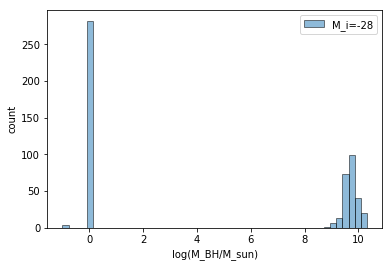

In [259]:
_, binning, _ = plt.hist(all_bands[(all_bands['M_i'] > -28.5) & (all_bands['M_i'] < -27.5)]['mass_BH'].values,
                         bins=50, color='tab:blue', edgecolor='k', alpha=0.5, label='M_i=-28')
plt.ylabel('count')
plt.xlabel('log(M_BH/M_sun)')
plt.legend()

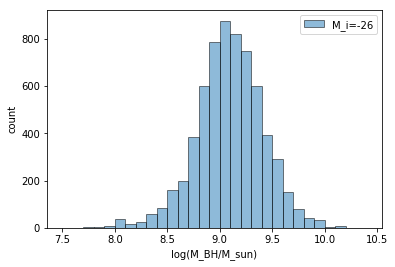

In [248]:
_, binning, _ = plt.hist(all_bands[(all_bands['M_i'] > -26.5) & (all_bands['M_i'] < -25.5)]['mass_BH'].values,
                         bins=np.arange(7.5, 10.5, 0.1), color='tab:blue', edgecolor='k', alpha=0.5, label='M_i=-26')
plt.ylabel('count')
plt.xlabel('log(M_BH/M_sun)')
plt.legend()

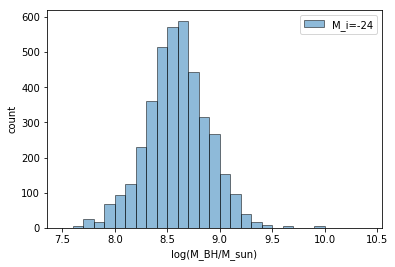

In [249]:
_, binning, _ = plt.hist(all_bands[(all_bands['M_i'] > -24.5) & (all_bands['M_i'] < -23.5)]['mass_BH'].values,
                         bins=np.arange(7.5, 10.5, 0.1), color='tab:blue', edgecolor='k', alpha=0.5, label='M_i=-24')
plt.ylabel('count')
plt.xlabel('log(M_BH/M_sun)')
plt.legend()

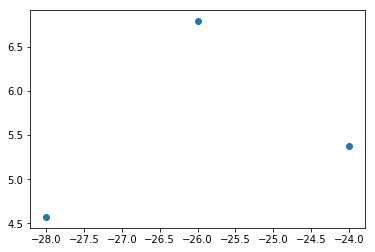

In [250]:
means = [np.mean(all_bands[(all_bands['M_i'] > -28.5) & (all_bands['M_i'] < -27.5)]['mass_BH'].values),
         np.mean(all_bands[(all_bands['M_i'] > -26.5) & (all_bands['M_i'] < -25.5)]['mass_BH'].values),
         np.mean(all_bands[(all_bands['M_i'] > -24.5) & (all_bands['M_i'] < -23.5)]['mass_BH'].values)]
plt.scatter([-28, -26, -24], means)

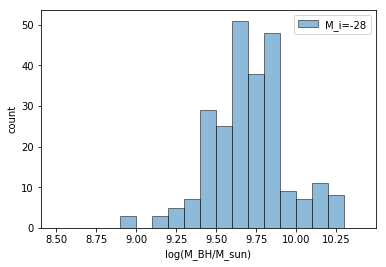

In [254]:
_, binning, _ = plt.hist(fit_qso[(fit_qso['M_i'] > -28.5) & (fit_qso['M_i'] < -27.5)]['mass_BH'].values,
                         bins=np.arange(8.5, 10.5, 0.1), color='tab:blue', edgecolor='k', alpha=0.5, label='M_i=-28')
plt.ylabel('count')
plt.xlabel('log(M_BH/M_sun)')
plt.legend()

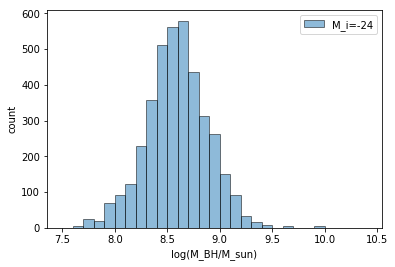

In [256]:
_, binning, _ = plt.hist(fit_qso[(fit_qso['M_i'] > -24.5) & (fit_qso['M_i'] < -23.5)]['mass_BH'].values,
                         bins=np.arange(7.5, 10.5, 0.1), color='tab:blue', edgecolor='k', alpha=0.5, label='M_i=-24')
plt.ylabel('count')
plt.xlabel('log(M_BH/M_sun)')
plt.legend()

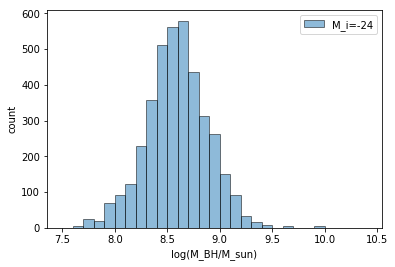

In [257]:
_, binning, _ = plt.hist(fit_qso[(fit_qso['M_i'] > -24.5) & (fit_qso['M_i'] < -23.5)]['mass_BH'].values,
                         bins=np.arange(7.5, 10.5, 0.1), color='tab:blue', edgecolor='k', alpha=0.5, label='M_i=-24')
plt.ylabel('count')
plt.xlabel('log(M_BH/M_sun)')
plt.legend()

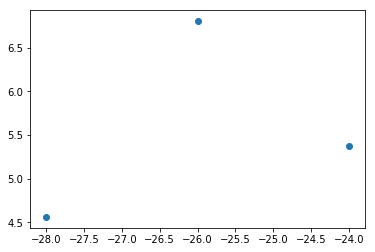

In [258]:
means = [np.mean(fit_qso[(fit_qso['M_i'] > -28.5) & (fit_qso['M_i'] < -27.5)]['mass_BH'].values),
         np.mean(fit_qso[(fit_qso['M_i'] > -26.5) & (fit_qso['M_i'] < -25.5)]['mass_BH'].values),
         np.mean(fit_qso[(fit_qso['M_i'] > -24.5) & (fit_qso['M_i'] < -23.5)]['mass_BH'].values)]
plt.scatter([-28, -26, -24], means)

In [94]:
np.arange(7.5, 11.0, 0.5)

array([ 7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5])

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.00189798],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.00189798, 0.00189798, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.00379595, 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 array([-2.27655 , -2.199972, -2.123394, -2.046816, -1.970238, -1.89366 ,
        -1.817082, -1.740504, -1.663926, -1.587348, -1.51077 , -1.434192,
        -1.357614, -1.281036, -1.204458, -1.12788 , -1.051302, -0.974724,
        -0.898146, -0.821568, -0.74499 , -0.668412, -0.591834, -0.515256,
        -0.438678, -0.3621  , -0.285522, -0.208944, -0.132366, -0.055788,
         0.02079 ,  0.097368,  0.173946

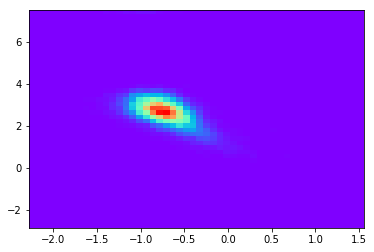

In [17]:
x = all_bands['log_sf']
y = all_bands['log_tau']
plt.hist2d(x, y, bins=50, normed=True, cmap = plt.cm.rainbow)

In [30]:
drw_dict['u'].head()

,SDR5ID,ra,dec,redshift,M_i,mass_BH,chi2,log_tau,log_sf,log_tau_lowlim,log_tau_uplim,log_sf_lowlim,log_sf_uplim,edge,Plike,Pnoise,Pinf,mu,Npts
0,301,2.169302,1.238649,1.0730,-23.901,0.000,0.968284,1.99550,-0.723982,1.53265,3.72459,-1.232570,-0.584464,0,94.7333,90.6945,92.8552,20.7869,60
1,144,1.091028,0.962126,0.7867,-23.399,0.000,1.141170,2.27673,-0.325921,2.08917,4.02532,-0.510504,-0.261182,0,63.9319,42.5078,62.2803,20.7824,47
2,58,0.331289,0.177230,1.6199,-24.735,0.000,1.232880,1.87484,-0.318620,1.62701,3.03110,-0.636571,-0.236789,0,72.3127,61.8195,69.3966,20.5453,53
3,190,1.364696,-0.098956,0.6125,-23.121,0.000,1.023900,2.47534,-0.394771,2.32222,4.21751,-0.522501,-0.354452,0,99.8258,56.6434,98.5452,19.8859,57
4,36,0.221552,-0.292485,2.7563,-26.451,9.361,1.106910,1.70714,-0.521248,1.28728,3.62220,-1.096090,-0.386069,0,81.7920,78.9905,79.9715,20.6848,55


In [52]:
qso_df.head()

,dbID,RA,DEC,SDR5ID,M_i,M_i_corr,redshift,mass_BH,Lbol,u,g,r,i,z,Au
0,#,----------------------------------------------...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000840.63+011419.1,2.169302,1.238649,1.0730,20.793,0.074,20.469,0.028,20.197,0.031,20.040,0.055,20.000,0.111,0.116
2,000421.84+005743.6,1.091028,0.962126,0.7867,20.790,0.097,20.183,0.040,19.849,0.024,19.818,0.037,19.430,0.078,0.183
3,000119.50+001038.0,0.331289,0.177230,1.6199,20.892,0.102,20.554,0.028,20.431,0.035,20.199,0.042,20.099,0.152,0.154
4,000527.52-000556.2,1.364696,-0.098956,0.6125,20.098,0.046,19.722,0.025,19.784,0.031,19.485,0.023,19.541,0.069,0.178


In [8]:
for dtype in ['float','int','object']:
    selected_dtype = df.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 1.45 MB
Average memory usage for int columns: 1.14 MB
Average memory usage for object columns: 0.00 MB


In [9]:
int_types = ["uint8", "int8", "int16"]
for it in int_types:
    print(np.iinfo(it))

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------



4.58 MB
2.29 MB


,before,after
uint32,NaN,3.0
int64,3.0,NaN


In [266]:
log_edd = np.log10(1.5) + 38.0 + shen['mass_BH'].values
log_edd_ratio = shen['Lbol'].values - log_edd
shen['log_edd_ratio'] = log_edd_ratio

# [np.arange(7.4, 10.9, 0.1), np.arange(-29, -23, 0.1), np.arange(0.5, 3.5, 0.1)]
H, edges = np.histogramdd(shen[['mass_BH', 'M_i', 'log_edd_ratio']].values,
                          bins=[np.arange(7.4, 11.0, 0.25), np.arange(-29, -22.5, 0.5), np.arange(-2.0, 1.0, 0.01)])
H.shape, edges[0].size, edges[1].size, edges[2].size

#np.mean(H, axis=2).T

#plt.figure(figsize=(12, 6))
plt.imshow(np.mean(H, axis=2).T,
           interpolation=None, origin='low', extent=[edges[0][0], edges[0][-1]+0.25, edges[1][0], edges[1][-1] + 0.5],
           cmap='jet', vmin=0.5, vmax=3.5, aspect='auto')
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.ax.set_ylabel('log L/Ledd')
plt.ylabel('M_i')
plt.xlabel('log(M_BH/M_sun)')

from scipy import stats

stats = stats.binned_statistic_dd(sample=shen[['mass_BH', 'M_i']].values,
                                values=shen['log_edd_ratio'].values,
                               bins=[np.arange(7.4, 11.0, 0.25), np.arange(-29, -22.5, 0.5)],
                                statistic='mean',
                               )

edd_2d = np.nan_to_num(stats.statistic)

plt.imshow(edd_2d,
           interpolation=None, origin='low', extent=[edges[0][0], edges[0][-1]+0.25, edges[1][0], edges[1][-1] + 0.5],
           cmap='jet', vmin=0.5, vmax=3.5, aspect='auto')
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.ax.set_ylabel('log L/Ledd')
plt.ylabel('M_i')
plt.xlabel('log(M_BH/M_sun)')

27.47 MB
13.73 MB


,before,after
float32,NaN,18.0
float64,18.0,NaN


32.04 MB
16.02 MB


In [ ]:
def reduce_size(big_df, keep_cols):
    big_df = big_df[keep_cols]
    